In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import (
    precision_recall_curve, auc, average_precision_score, roc_curve, accuracy_score,
    classification_report, roc_auc_score, precision_recall_fscore_support
)
import numpy as np
import pandas as pd
import IPython.display as display

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from path_location import folder_location


In [2]:
import gc
gc.collect()

0

In [3]:
import pandas as pd

features_to_use = [
    "execution_timeliness_after_trans", "execution_timeliness_before_trans", "execution_timeliness_on_trans",
    "filing_timeliness_early_filing", "filing_timeliness_late_filing", "filing_timeliness_on_time_filing",
    "filing_lag_days", "TRANS_CODE_I", "TRANS_CODE_P", "TRANS_CODE_S", 'y_pred', "TRANS_CODE_G", "TRANS_CODE_J"
]
label = "y_pred"
dtypes = {
    "execution_timeliness_after_trans": "float32",
    "execution_timeliness_before_trans": "float32",
    "execution_timeliness_on_trans": "float32",
    "filing_timeliness_early_filing": "int8",
    "filing_timeliness_late_filing": "int8",
    "filing_timeliness_on_time_filing": "int8",
    "filing_lag_days": "float32",
    "TRANS_CODE_I": "int8",
    "TRANS_CODE_P": "int8",
    "TRANS_CODE_S": "int8",
    "TRANS_CODE_G": "int8",
    "TRANS_CODE_J": "int8",
    "y_pred": "float32"
}
FOLDER = folder_location.PROCESSED_DATA_FOLDER
TRAINNG_FEATURES_FILE = folder_location.TRAINING_BASELINE_FULL_FEATURES_FILE
TESTING_FEATURES_FILE = folder_location.TESTING_BASELINE_FULL_FEATURES_FILE

train = pd.read_csv(f"{FOLDER}/{TRAINNG_FEATURES_FILE}", usecols=features_to_use, dtype=dtypes)
test = pd.read_csv(f"{FOLDER}/{TESTING_FEATURES_FILE}", usecols=features_to_use, dtype=dtypes)


In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1417896, 13)
Test shape: (347020, 13)


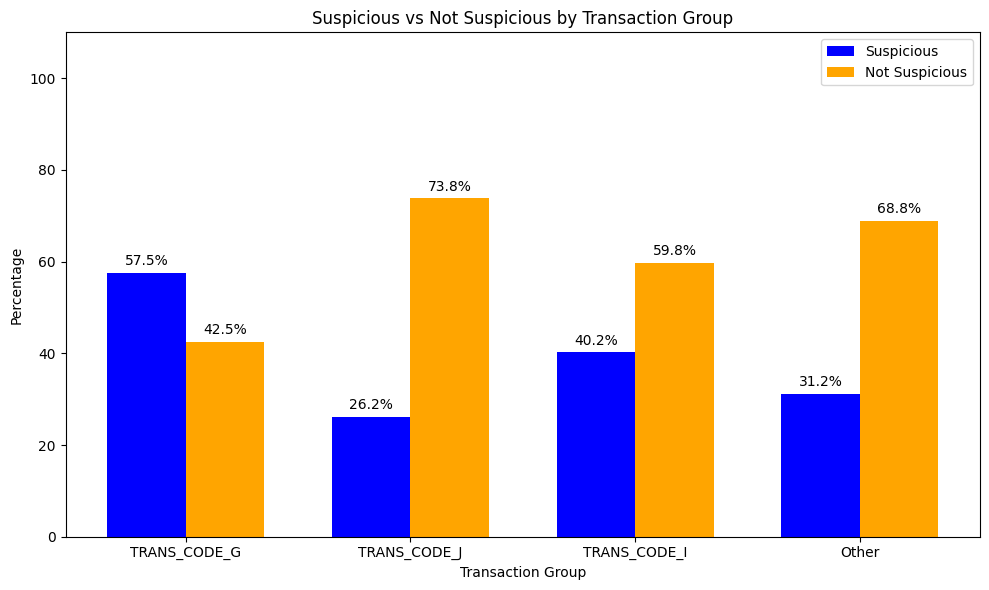

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label = 'y_pred'

# define masks
is_G = train["TRANS_CODE_G"] == 1
is_J = train["TRANS_CODE_J"] == 1
is_I = train["TRANS_CODE_I"] == 1

is_Other = ~is_G & ~is_J & ~is_I

# define function to get counts
def get_group(label_mask):
    suspicious = train[label_mask & (train[label] == 1)].shape[0]
    not_suspicious = train[label_mask & (train[label] == 0)].shape[0]
    total = suspicious + not_suspicious
    if total == 0:
        return (0, 0)
    return (suspicious / total * 100, not_suspicious / total * 100)

g_susp, g_not = get_group(is_G)
j_susp, j_not = get_group(is_J)
i_susp, i_not = get_group(is_I)
o_susp, o_not = get_group(is_Other)

# data for plotting
groups = ['TRANS_CODE_G', 'TRANS_CODE_J', 'TRANS_CODE_I','Other']
suspicious_vals = [g_susp, j_susp, i_susp, o_susp]
not_suspicious_vals = [g_not, j_not, i_not, o_not]

x = range(len(groups))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar([i - bar_width/2 for i in x], suspicious_vals, width=bar_width, label='Suspicious', color='blue')
bars2 = plt.bar([i + bar_width/2 for i in x], not_suspicious_vals, width=bar_width, label='Not Suspicious', color='orange')

# annotate with %
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')

plt.xticks(x, groups)
plt.xlabel('Transaction Group')
plt.ylabel('Percentage')
plt.title('Suspicious vs Not Suspicious by Transaction Group')
plt.legend()
plt.ylim(0, 110)
plt.tight_layout()
plt.show()


In [6]:
## To see how many from the train set are filtered out
train_unfiltered = train[(train["TRANS_CODE_P"] != 1) & (train["TRANS_CODE_S"] != 1)].copy()
print(train_unfiltered.shape[0], "rows are filtered out from the train set")
print(train_unfiltered[train_unfiltered["y_pred"] == 1].shape[0], "rows are labelled suspicious") # 67053

170571 rows are filtered out from the train set
67053 rows are labelled suspicious


___
# Helper functions
___

In [7]:
# -----------------------------------------------------------------------------
# Helper: Find threshold to meet target recall
# -----------------------------------------------------------------------------
def find_threshold_for_recall(y_true, probs, target_recall=0.75, num_steps=200):
    thresholds = np.linspace(0, 1, num_steps)
    best_thr, best_diff = 0.5, float("inf")
    for thr in thresholds:
        y_pred = (probs >= thr).astype(int)
        _, rec, _, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        diff = abs(rec - target_recall)
        if diff < best_diff:
            best_diff, best_thr = diff, thr
    return best_thr

# -----------------------------------------------------------------------------
# Helper: Plot precision-recall curve
# -----------------------------------------------------------------------------

def plot_precision_recall_curve(y_test, y_probs):
    # Compute precision-recall pairs
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_probs)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    print("Area under PR curvere:", round(pr_auc,3))
    print("Average precision score:", round(avg_precision,3))
    print("Area under ROC curve", round(roc_auc,3)) 

    # Create side-by-side plots
    _, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Precision-Recall curve
    axs[0].plot(recall, precision, color='blue', label=f"PR AUC = {pr_auc:.4f}")
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title("Precision-Recall Curve")
    axs[0].grid(True)
    axs[0].legend()

    # Plot ROC curve
    axs[1].plot(fpr, tpr, color='green', label=f"ROC AUC = {roc_auc:.4f}")
    axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC Curve")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

___
# Run Random Forest Classifier
___

In [8]:
#from sklearnex import patch_sklearn
#patch_sklearn()

# -----------------------------------------------------------------------------
# Filter rows to only TRANS_CODE_P or TRANS_CODE_S to emulate SEC's model
# -----------------------------------------------------------------------------
train_filtered = train[(train["TRANS_CODE_P"] == 1) | (train["TRANS_CODE_S"] == 1)].copy()
test_filtered = test[(test["TRANS_CODE_P"] == 1) | (test["TRANS_CODE_S"] == 1)].copy()

cols_to_drop = [col for col in train.columns if col.startswith("TRANS_CODE") and col not in ["TRANS_CODE_P", "TRANS_CODE_S"]]
train_filtered.drop(columns=cols_to_drop, inplace=True)
test_filtered.drop(columns=cols_to_drop, inplace=True)

X_train = train_filtered.drop(columns=[label])
y_train = train_filtered[label].astype(int)
X_test = test_filtered.drop(columns=[label])
y_test = test_filtered[label].astype(int)

# -----------------------------------------------------------------------------
# Train Random Forest Classifier and predict probabilities
# -----------------------------------------------------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get prediction probabilities for the test set (probability for class 1)
y_probs = rf.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# Evaluate at a default threshold of 0.5
# -----------------------------------------------------------------------------
y_pred_50 = (y_probs >= 0.5).astype(int)
report_50 = pd.DataFrame(classification_report(
    y_test, y_pred_50, output_dict=True, zero_division=0)
).T
report_50.name = "Threshold = 0.5"

# -----------------------------------------------------------------------------
# Find optimal threshold to target recall ≈ 0.75 for class 1
# -----------------------------------------------------------------------------
best_thresh = find_threshold_for_recall(y_test, y_probs, target_recall=0.75)

# Evaluate using the best threshold found
y_pred_best = (y_probs >= best_thresh).astype(int)
report_best = pd.DataFrame(classification_report(
    y_test, y_pred_best, output_dict=True, zero_division=0)
).T
report_best.name = f"Threshold for Recall 1 ≈ 0.75 (Threshold ≈ {best_thresh:.2f})"

# -----------------------------------------------------------------------------
# Reintroduce G, J, I in test set and recompute probablities. Cast rows with G, J, I codes to 0
# -----------------------------------------------------------------------------
X_test_unfiltered = test.drop(columns=cols_to_drop + [label])
y_test_unfiltered = test[label].astype(int)

y_probs_unfiltered = rf.predict_proba(X_test_unfiltered)[:, 1]
# Use the same best_thresh found earlier
y_pred_unfiltered = (y_probs_unfiltered >= best_thresh).astype(int)

# Replace predictions for rows not marked by G, J, I with the model's predictions
# Create a full prediction vector with all predictions set to 0 by default
y_pred_forced = np.zeros(len(y_pred_unfiltered), dtype=int)
# Create a mask for rows that do NOT have any of the TRANS_CODE_G, TRANS_CODE_J, TRANS_CODE_I flags set
mask_non_GJI_test = (test["TRANS_CODE_G"] == 0) & (test["TRANS_CODE_J"] == 0) & (test["TRANS_CODE_I"] == 0)
y_pred_forced[mask_non_GJI_test] = y_pred_unfiltered[mask_non_GJI_test] 

# Evaluate forced predictions against the true label (assumed to be in full_df["y_pred"])
report_forced = pd.DataFrame(classification_report(
    y_test_unfiltered, y_pred_forced, output_dict=True, zero_division=0)
).T
report_forced.name = "Hypothetical difference in true classification numbers due to exclusion of J, G and I"

for report_df in [report_50, report_best, report_forced]:
    display.display(report_df.style.set_caption(report_df.name).format("{:.2f}"))


,precision,recall,f1-score,support
0,0.63,0.99,0.77,184424.00
1,0.41,0.01,0.01,109970.00
accuracy,0.63,0.63,0.63,0.63
macro avg,0.52,0.50,0.39,294394.00
weighted avg,0.55,0.63,0.49,294394.00


,precision,recall,f1-score,support
0,0.64,0.30,0.41,184424.00
1,0.38,0.72,0.50,109970.00
accuracy,0.46,0.46,0.46,0.46
macro avg,0.51,0.51,0.46,294394.00
weighted avg,0.54,0.46,0.44,294394.00


,precision,recall,f1-score,support
0,0.61,0.40,0.48,213483.00
1,0.38,0.59,0.46,133537.00
accuracy,0.47,0.47,0.47,0.47
macro avg,0.49,0.49,0.47,347020.00
weighted avg,0.52,0.47,0.47,347020.00


## Plot ROC Curves

Area under PR curvere: 0.389
Average precision score: 0.389
Area under ROC curve 0.525


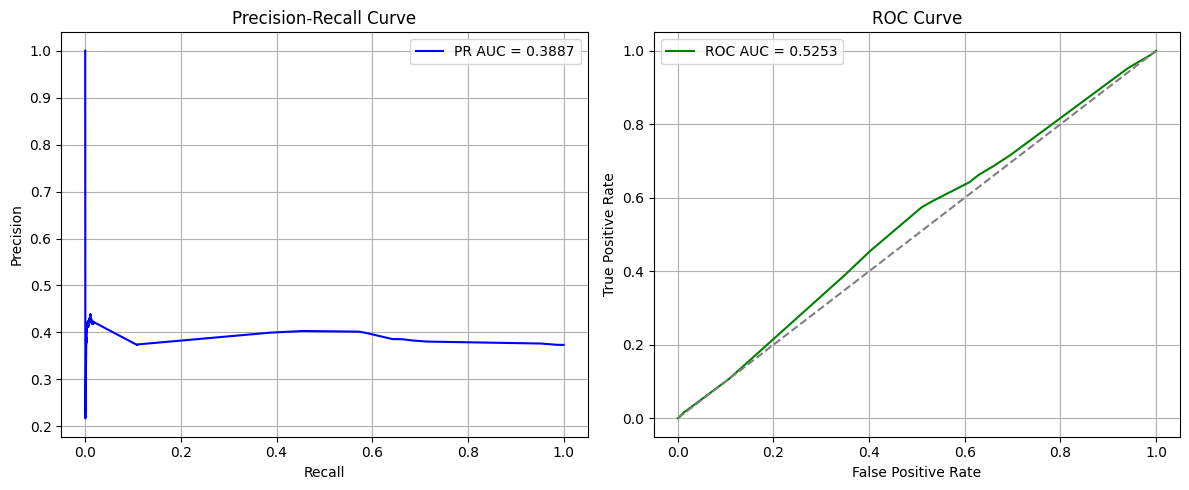

In [9]:
plot_precision_recall_curve(y_test, y_probs)

Area under PR curvere: 0.308
Average precision score: 0.385
Area under ROC curve 0.5


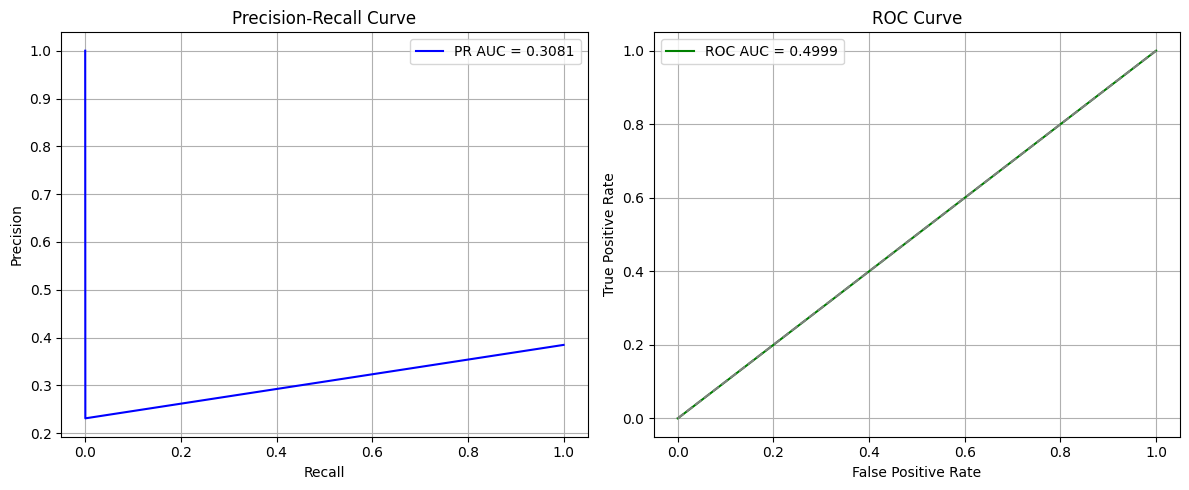

In [10]:
# Create a full prediction vector with all predictions set to 0 by default
y_prob_forced = np.zeros(len(y_probs_unfiltered), dtype=int)
# Replace predictions for rows not marked by G, J, I with the model's predictions
y_prob_forced[mask_non_GJI_test] = y_probs_unfiltered[mask_non_GJI_test] 

plot_precision_recall_curve(y_test_unfiltered, y_prob_forced)

In [12]:
# do not overwrite below hehe

# Old code below to delete?

### These are the amount SEC misses from J and G codes based on traditional models

In [13]:
train_dropped_j_g = train[(train["TRANS_CODE_G"] == 0) & (train["TRANS_CODE_J"] == 0)]
train_dropped_j_g_x = train_dropped_j_g[features_to_use]
train_dropped_j_g_y = train_dropped_j_g[label]

In [14]:
train_dropped_j_g_x

,execution_timeliness_after_trans,execution_timeliness_before_trans,execution_timeliness_on_trans,filing_timeliness_early_filing,filing_timeliness_late_filing,filing_timeliness_on_time_filing,filing_lag_days,TRANS_CODE_I,TRANS_CODE_P,TRANS_CODE_S,y_pred,TRANS_CODE_G,TRANS_CODE_J
0,0.0,0.0,1.0,0,1,0,0.408725,0,0,1,1.0,0,0
1,0.0,0.0,1.0,0,1,0,0.408725,0,0,1,1.0,0,0
2,0.0,0.0,1.0,0,1,0,0.411298,0,0,1,0.0,0,0
3,0.0,0.0,1.0,0,1,0,0.410850,0,0,1,0.0,0,0
4,0.0,0.0,1.0,0,1,0,0.408949,0,0,1,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417889,0.0,0.0,1.0,0,1,0,0.408837,0,1,0,1.0,0,0
1417890,0.0,0.0,1.0,0,1,0,0.408949,0,1,0,0.0,0,0
1417893,0.0,0.0,1.0,0,0,1,0.408501,0,1,0,0.0,0,0
1417894,0.0,0.0,1.0,0,1,0,0.408949,0,1,0,1.0,0,0


In [15]:
test_extract_x = test[features_to_use]
test_extract_y = test[label]

In [16]:
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(train_dropped_j_g_x, train_dropped_j_g_y)

# Predict on test set
y_pred = rf.predict(test_extract_x)

# Evaluate performance
print("Accuracy:", accuracy_score(test_extract_y, y_pred))
print("Classification Report:\n", classification_report(test_extract_y, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    213483
         1.0       1.00      1.00      1.00    133537

    accuracy                           1.00    347020
   macro avg       1.00      1.00      1.00    347020
weighted avg       1.00      1.00      1.00    347020



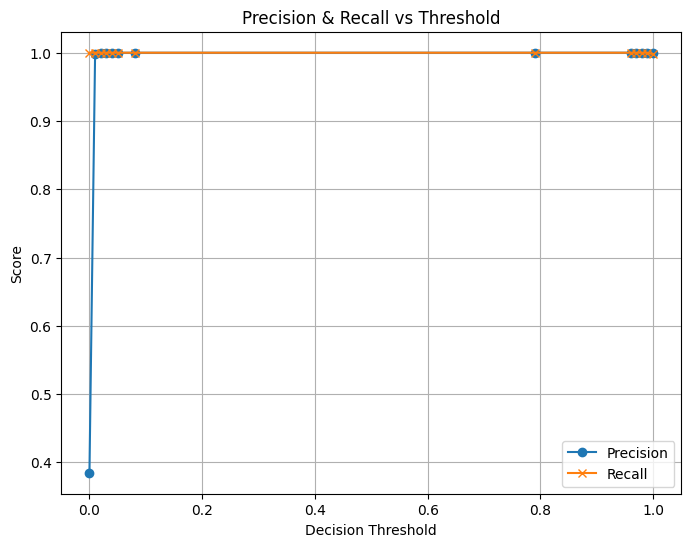

In [17]:
from sklearn.metrics        import recall_score, classification_report, precision_recall_curve
probs = rf.predict_proba(test_extract_x)[:,1]
precision_vals, recall_vals, thresholds = precision_recall_curve(test_extract_y, probs, pos_label=1)
    
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision_vals[:-1], label="Precision", marker="o")
plt.plot(thresholds, recall_vals[:-1],    label="Recall",    marker="x")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title(f"Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
precision = precision_vals[:-1]
recall = recall_vals[:-1]

# Filter indices where recall >= 0.7
valid_indices = np.where(recall >= 0.7)[0]

if len(valid_indices) > 0:
    # Among valid recall values, find the one with highest precision
    best_index = valid_indices[np.argmax(precision[valid_indices])]

    best_threshold = thresholds[best_index]
    best_precision = precision[best_index]
    best_recall = recall[best_index]

    print(f"Best Threshold (Recall ≥ 0.7 with highest Precision): {best_threshold:.4f}")
    print(f"Precision: {best_precision:.4f}")
    print(f"Recall: {best_recall:.4f}")
else:
    print("No threshold found with recall ≥ 0.7")

Best Threshold (Recall ≥ 0.7 with highest Precision): 0.7900
Precision: 1.0000
Recall: 1.0000


In [19]:
y_pred_tuned = (probs >= 0.2983).astype(int)
from sklearn.metrics import classification_report
print("Accuracy:", accuracy_score(test_extract_y, y_pred_tuned))
print("Classification Report:\n", classification_report(test_extract_y, y_pred_tuned))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    213483
         1.0       1.00      1.00      1.00    133537

    accuracy                           1.00    347020
   macro avg       1.00      1.00      1.00    347020
weighted avg       1.00      1.00      1.00    347020



# Get final results

In [20]:
## To see how many from the train set are filtered out
train_unfiltered = train[(train["TRANS_CODE_P"] != 1) & (train["TRANS_CODE_S"] != 1)].copy()
print(train_unfiltered.shape[0], "rows are filtered out from the train set")
print(train_unfiltered[train_unfiltered["y_pred"] == 1].shape[0], "rows are labelled suspicious") # 67053

170571 rows are filtered out from the train set
67053 rows are labelled suspicious
